In [1]:
%matplotlib inline
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data.dataloader import default_collate
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import gradcheck
from IPython.display import clear_output
from torch.autograd import Variable
from mpl_toolkits.mplot3d import Axes3D
print(torch.__version__)

1.1.0


### Dataset Class (loads data from csv)

In [3]:
reqd_len = 100
channels = 3
classes = 4
class IMUDataset(Dataset):
    def __init__(self, mode = 'test', transform = None):
        if mode == 'train' :
            self.df = pd.read_csv('../data/new_train.csv', header = None)
        elif mode == 'test' :
            self.df = pd.read_csv('../data/new_test.csv', header = None)
        elif mode == 'val' :
            self.df = pd.read_csv('../data/new_val.csv', header = None)
        self.transform = transform
        print(self.df.shape)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        y = self.df.iloc[idx : idx + reqd_len, 3 : ].values
        ind = np.argmax(np.sum(y, axis = 0))
        label = np.zeros_like(self.df.iloc[0, 3 : ].values)
        label = label.astype('float')
        label[ind] = 1
        x = self.df.iloc[idx : idx + reqd_len, : channels].values
        x = x.astype('float')
        x = x.reshape(reqd_len, channels)
        assert(x.shape == (reqd_len, channels))
        assert(label.shape == (classes, ))
        return x, label
        
trainset = IMUDataset(mode = 'train')
valset = IMUDataset(mode = 'val')
testset = IMUDataset(mode = 'test')

(42600, 7)
(5300, 7)
(5400, 7)


### Dataloader definitions (provides data in iterable form)

In [4]:
train_batch_size = 16
batch_size = 16
train_indices = [(i * reqd_len) for i in range(len(trainset) // reqd_len)]
val_indices = [(i * reqd_len) for i in range(len(valset) // reqd_len)]
test_indices = [(i * reqd_len) for i in range(len(testset) // reqd_len)]

trainloader = DataLoader(trainset, batch_size = train_batch_size, sampler = SubsetRandomSampler(train_indices), drop_last = True)
valloader = DataLoader(valset, batch_size = batch_size, sampler = SubsetRandomSampler(val_indices), drop_last = True)
testloader = DataLoader(testset, batch_size = batch_size, sampler = SubsetRandomSampler(test_indices), drop_last = True)

# signal, label = next(iter(trainloader))
# print(signal.shape)
# print(label.shape)

In [5]:
def output_size(n, f, p = 0, s = 1):
    ''' Returns output size for given input size (n), filter size (f), padding (p) and stride (s)
    for a convolutional layer
    '''
    return (((n + 2 * p - f) / s) + 1)

output_size(50, 5)
output_size(46, 5)

42.0

In [66]:
# sig, lab = next(iter(trainloader))
# sig2 = sig
# sig = torch.transpose(sig, 1, 2)
# sig = sig.reshape(-1, 150)
# sig_ = sig.numpy()
# sig2_ = sig2.numpy()
# plt.plot(sig_[0])
# plt.plot(sig2_[0])

In [58]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # defining layers
        self.conv1 = nn.Conv1d(3, 5, 3)
        self.conv2 = nn.Conv1d(5, 10, 3)
        self.pamap = nn.Linear(96 * 10, 12)
        self.robogame = nn.Linear(96 * 10, 4)
        
        nn.init.xavier_uniform_(self.conv1.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.conv2.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.pamap.weight, gain = nn.init.calculate_gain('sigmoid'))
        nn.init.xavier_uniform_(self.robogame.weight, gain = nn.init.calculate_gain('sigmoid'))
        
    # use flag = True during fine-tuning 
    def forward(self, signal, flag = False):
        signal = torch.transpose(signal, 1, 2)
        out = F.relu(self.conv1(signal))
        out = F.relu(self.conv2(out))
        out = torch.transpose(out, 1, 2)
        out = out.reshape(-1, 96 * 10)
        if flag : 
            out = self.robogame(out)
        else :
            out = self.pamap(out)
        return out

Net = ConvNet().double()
if torch.cuda.is_available():
    print('Model on GPU')
    Net = Net.cuda()
    
Net.load_state_dict(torch.load('../saved_models/model1.pt', map_location = 'cpu'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [59]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, Net.parameters()), lr = 1e-3)
# optimizer = optim.SGD(Net.parameters(), lr = 1e-3)

In [60]:
num_epochs = 100
total_step = len(trainset) // (train_batch_size * reqd_len)
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, (images, labels) in enumerate(trainloader) :
        if torch.cuda.is_available():
            images = Variable(images).cuda().double()
            images.requires_grad = True
            labels = Variable(labels).cuda()
        else : 
            images = Variable(images).double()
            images.requires_grad = True
            labels = Variable(labels)
        
        _, target = torch.max(labels, 1)

        y_pred = Net.forward(images, flag = True)
        
        loss = F.cross_entropy(y_pred, target)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 20 == 0 :
#             print('Gradient Check : ', gradcheck(Net, (images, )))
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    Net.eval()
    val = []
    with torch.no_grad() :
        for i, (images, labels) in enumerate(testloader) :
            if torch.cuda.is_available():
                images = Variable(images).cuda().double()
                labels = Variable(labels).cuda()
            else : 
                images = Variable(images).double()
                labels = Variable(labels)
                
            _, target = torch.max(labels, 1)

            # Forward pass
            outputs = Net.forward(images, flag = True)
            loss = F.cross_entropy(outputs, target)
            val.append(loss)

    val_loss = (sum(val) / len(val)).item()
    val_loss_list.append(val_loss)
    print('epoch : ', epoch, ' / ', num_epochs, ' | TL : ', train_loss, ' | VL : ', val_loss)
    
    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(Net.state_dict(), '../saved_models/model2_finetuning.pt')

epoch =  0  step =  0  of total steps  26  loss =  1.5333510754403978
epoch =  0  step =  20  of total steps  26  loss =  1.0978544836025799
epoch :  0  /  100  | TL :  1.237896689509165  | VL :  1.2550600547174648
saving model
epoch =  1  step =  0  of total steps  26  loss =  1.0305388172273648
epoch =  1  step =  20  of total steps  26  loss =  1.1783458179974768
epoch :  1  /  100  | TL :  1.1809112508867095  | VL :  1.2765019480702655
epoch =  2  step =  0  of total steps  26  loss =  1.1966728531682653
epoch =  2  step =  20  of total steps  26  loss =  1.0839863196911328
epoch :  2  /  100  | TL :  1.1478598357213994  | VL :  1.2674307126214537
epoch =  3  step =  0  of total steps  26  loss =  1.0906629785970212
epoch =  3  step =  20  of total steps  26  loss =  1.0095099075460423
epoch :  3  /  100  | TL :  1.1294520491224789  | VL :  1.2345538943513714
saving model
epoch =  4  step =  0  of total steps  26  loss =  1.0625042790184276
epoch =  4  step =  20  of total steps  2

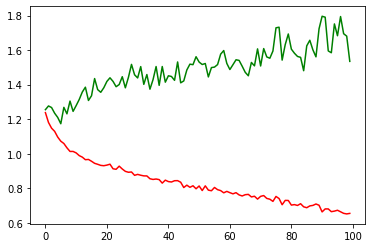

In [61]:
j = np.arange(100)
plt.plot(j, train_loss_list, 'r', j, val_loss_list, 'g')

In [62]:
def _get_accuracy(dataloader, Net):
    total = 0
    correct = 0
    Net.eval()
    for i, (images, labels) in enumerate(dataloader):
        images = Variable(images).double()
        labels = Variable(labels).double()
        
        if torch.cuda.is_available() : 
            images = images.cuda()
            labels = labels.cuda()

        outputs = Net.forward(images, flag = True)
        outputs = F.log_softmax(outputs, dim = 1)
    
        _, label_ind = torch.max(labels, 1)
        _, pred_ind = torch.max(outputs, 1)
        
        # converting to numpy arrays
        label_ind = label_ind.data.cpu().numpy()
        pred_ind = pred_ind.data.cpu().numpy()
        
        # get difference
        diff_ind = label_ind - pred_ind
        # correctly classified will be 1 and will get added
        # incorrectly classified will be 0
        correct += np.count_nonzero(diff_ind == 0)
        total += len(diff_ind)

    accuracy = correct / total
    # print(len(diff_ind))
    return accuracy

Net = Net.eval()

print(_get_accuracy(trainloader, Net) * 100, '/', _get_accuracy(valloader, Net) * 100, '/', _get_accuracy(testloader, Net) * 100)

testing_Net = ConvNet()
testing_Net.load_state_dict(torch.load('../saved_models/model2_finetuning.pt'))
testing_Net.eval().double()
print(_get_accuracy(trainloader, testing_Net) * 100, '/', _get_accuracy(valloader, testing_Net) * 100, '/', _get_accuracy(testloader, testing_Net) * 100)

79.5673076923077 / 54.166666666666664 / 39.58333333333333
59.375 / 54.166666666666664 / 45.83333333333333


#### Directly training NNs on raw data doesn't work well (network overfits most of the time). So, we can try to use some pre-processing to the data before training (like running mean, running std deviation, running rms, etc.)

### PyTorch implementation of `running_mean`

In [85]:
def running_mean(signal, window_size = 10):
    ''' Returns running mean of 3D signal (batch_size, length, channels)
    '''
    mean = torch.zeros_like(signal)
    for i in range(signal.shape[0]) :
        for j in range(signal.shape[1] - window_size) : 
            mean[i][j] = signal[i][j : j + window_size].mean(dim = 0)
            
    for i in range(signal.shape[0]) :
        for j in range(signal.shape[1] - window_size, signal.shape[1]) :
            mean[i][j] = signal[i][j]
            
    return mean

### Shows working of `running_mean` function

torch.Size([16, 50, 3])


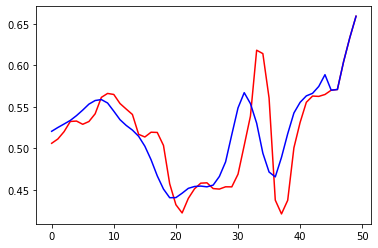

In [87]:
signal, label = next(iter(trainloader))
# print(signal.shape)
# print(signal[2].shape)
# print(signal[2].mean(dim = 0).shape)
# print(signal[2][ : 10].mean(dim = 0).shape)
# print(signal[1][2].shape)
mean = running_mean(signal, window_size = 5)
print(mean.shape)
sig_ = signal[0].transpose(0, 1)
mean_ = mean[0].transpose(0, 1)
t = range(50)
plt.plot(t, sig_[1].data.numpy(), 'r', t, mean_[1].data.numpy(), 'b')

### Training network using `running_mean` processed data

In [88]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # defining layers
        self.conv1 = nn.Conv1d(3, 5, 3)
        self.conv2 = nn.Conv1d(5, 10, 3)
        self.fc1 = nn.Linear(46 * 10, 256)
        self.fc2 = nn.Linear(256, 64)
        self.pamap = nn.Linear(64, 12)
        self.robogame = nn.Linear(64, 4)
        
        nn.init.xavier_uniform_(self.conv1.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.conv2.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc1.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc2.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.pamap.weight, gain = nn.init.calculate_gain('sigmoid'))
        nn.init.xavier_uniform_(self.robogame.weight, gain = nn.init.calculate_gain('sigmoid'))
        
        self.conv1.requires_grad = False
        self.conv2.requires_grad = False
#         self.conv3.requires_grad = False
        self.fc1.requires_grad = False
        
    # use flag = True during fine-tuning 
    def forward(self, signal, flag = False):
        signal = torch.transpose(signal, 1, 2)
        out = F.relu(self.conv1(signal))
        out = F.relu(self.conv2(out))
        out = torch.transpose(out, 1, 2)
        out = out.reshape(-1, 46 * 10)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        if flag : 
            out = F.log_softmax(self.robogame(out), dim = 1)
        else :
            out = F.log_softmax(self.pamap(out), dim = 1)
        return out

Net = ConvNet().double()
if torch.cuda.is_available():
    print('Model on GPU')
    Net = Net.cuda()
    
Net.load_state_dict(torch.load('../saved_models/model5.pt', map_location = 'cpu'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [89]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net.parameters(), lr = 1e-3, weight_decay = 1e-3)

In [91]:
num_epochs = 20
total_step = len(trainset) // (train_batch_size * 150)
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, (images, labels) in enumerate(trainloader) :
        if torch.cuda.is_available():
            images = Variable(images).cuda().double()
            labels = Variable(labels).cuda()
        else : 
            images = Variable(images).double()
            labels = Variable(labels)
        
        _, target = torch.max(labels, 1)

        y_pred = Net(images)
        
        loss = criterion(y_pred, target)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 20 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    Net.eval()
    val = []
    with torch.no_grad() :
        for i, (images, labels) in enumerate(valloader) :
            if torch.cuda.is_available():
                images = Variable(images).cuda().double()
                labels = Variable(labels).cuda()
            else : 
                images = Variable(images).double()
                labels = Variable(labels)
                
            _, target = torch.max(labels, 1)

            # Forward pass
            outputs = Net(images)
            loss = criterion(outputs, target)
            val.append(loss)

    val_loss = (sum(val) / len(val)).item()
    val_loss_list.append(val_loss)
    print('epoch : ', epoch, ' / ', num_epochs, ' | TL : ', train_loss, ' | VL : ', val_loss)
    
    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(Net.state_dict(), '../saved_models/model5_finetuning.pt')

epoch =  0  step =  0  of total steps  24  loss =  40.38579961256982
epoch =  0  step =  20  of total steps  24  loss =  11.082769917554113
epoch =  0  step =  40  of total steps  24  loss =  4.386315553257795
epoch =  0  step =  60  of total steps  24  loss =  4.5303314611552725
epoch :  0  /  20  | TL :  10.175358823116795  | VL :  4.0957429852096086
saving model
epoch =  1  step =  0  of total steps  24  loss =  2.2734264813851945
epoch =  1  step =  20  of total steps  24  loss =  2.560068265577454
epoch =  1  step =  40  of total steps  24  loss =  5.460454538465867
epoch =  1  step =  60  of total steps  24  loss =  1.640364041251571
epoch :  1  /  20  | TL :  2.9486955296092665  | VL :  2.7871905952074583
saving model
epoch =  2  step =  0  of total steps  24  loss =  1.641685817389175
epoch =  2  step =  20  of total steps  24  loss =  3.171220095012442
epoch =  2  step =  40  of total steps  24  loss =  1.6949074627107763
epoch =  2  step =  60  of total steps  24  loss =  1.8

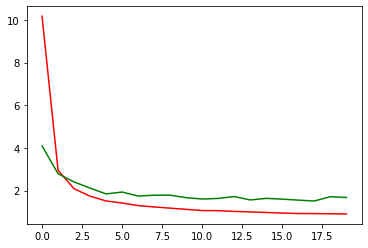

In [92]:
j = np.arange(20)
plt.plot(j, train_loss_list, 'r', j, val_loss_list, 'g')

In [95]:
def _get_accuracy(dataloader, Net):
    total = 0
    correct = 0
    Net.eval()
    for i, (images, labels) in enumerate(dataloader):
        images = Variable(images).double()
        labels = Variable(labels).double()

        outputs = Net(images)
    
        _, label_ind = torch.max(labels, 1)
        _, pred_ind = torch.max(outputs, 1)
        
        # converting to numpy arrays
        label_ind = label_ind.data.numpy()
        pred_ind = pred_ind.data.numpy()
        
        # get difference
        diff_ind = label_ind - pred_ind
        # correctly classified will be 1 and will get added
        # incorrectly classified will be 0
        correct += np.count_nonzero(diff_ind == 0)
        total += len(diff_ind)

    accuracy = correct / total
    # print(len(diff_ind))
    return accuracy

Net = Net.cpu().eval()
# _get_accuracy(trainloader)

In [96]:
print(_get_accuracy(trainloader, Net))
print(_get_accuracy(testloader, Net))
print(_get_accuracy(valloader, Net))

0.6429794520547946
0.4861111111111111
0.4166666666666667


In [99]:
testing_Net = ConvNet().double()
testing_Net.load_state_dict(torch.load('../saved_models/model5_finetuning.pt'))
testing_Net.eval()
print(_get_accuracy(trainloader, testing_Net))
print(_get_accuracy(testloader, testing_Net))
print(_get_accuracy(valloader, testing_Net))

0.6738013698630136
0.4722222222222222
0.4305555555555556


#### Even using `running_mean` processed data, the network again overfits. Even increasing window size didn't help (decreasing won't help as it will be closer to raw data then). Increasing too much is also not helpful as the plot will get more and more flat. So, we need to try out other features.

### PyTorch implementation of running standard deviation

In [125]:
def running_std_dev(signal, window_size = 10):
    ''' Returns running standard deviation of 3D signal (batch_size, length, channels)
    '''
    mean = torch.zeros_like(signal)
    for i in range(signal.shape[0]) :
        for j in range(signal.shape[1] - window_size) : 
            mean[i][j] = signal[i][j : j + window_size].std(dim = 0)
            
    for i in range(signal.shape[0]) :
        for j in range(signal.shape[1] - window_size, signal.shape[1]) :
            mean[i][j] = np.abs(signal[i][j])
            
    return mean

### Shows working of `running_std_dev` function

torch.Size([16, 50, 3])


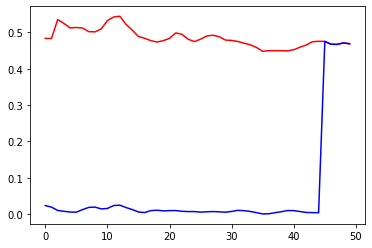

In [139]:
signal, label = next(iter(trainloader))
mean = running_std_dev(signal, window_size = 5)
print(mean.shape)
sig_ = signal[0].transpose(0, 1)
mean_ = mean[0].transpose(0, 1)
t = range(50)
plt.plot(t, sig_[0].data.numpy(), 'r', t, mean_[0].data.numpy(), 'b')

### Training network using `running_std_dev` processed data

In [127]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # defining layers
        self.conv1 = nn.Conv1d(3, 5, 3)
        self.conv2 = nn.Conv1d(5, 5, 3)
        self.fc1 = nn.Linear(46 * 5, 5)
        self.mp = nn.MaxPool1d(2, 2)
        self.dropout = nn.Dropout(p = 0.5)
        self.bn1 = nn.BatchNorm1d(num_features = 5)
        self.bn2 = nn.BatchNorm1d(num_features = 5)
        self.bnfc = nn.BatchNorm1d(num_features = 5)
        
        nn.init.xavier_uniform_(self.conv1.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.conv2.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc1.weight, gain = nn.init.calculate_gain('sigmoid'))
        
    def forward(self, signal):
        signal_ = running_std_dev(signal, window_size = 10)
        signal_ = signal_.view(-1, 3, 50)
        out = F.relu(self.conv1(signal_))
        out = self.bn1(out)
        out = F.relu(self.conv2(out))
        out = self.bn2(out)
        out = out.view(-1, 46 * 5)
        out = F.log_softmax(self.bnfc(self.fc1(out)), dim = 1)
        return out

Net = ConvNet()
if torch.cuda.is_available():
    print('Model on GPU')
    Net = Net.cuda()

In [128]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net.parameters(), lr = 1e-3)

In [129]:
num_epochs = 30
total_step = len(trainset) // (train_batch_size * 150)
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, (images, labels) in enumerate(trainloader) :
        if torch.cuda.is_available():
            images = Variable(images).cuda().float()
            labels = Variable(labels).cuda()
        else : 
            images = Variable(images).float()
            labels = Variable(labels)
        
        _, target = torch.max(labels, 1)

        y_pred = Net(images)
        
        loss = criterion(y_pred, target)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 20 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    Net.eval()
    val = []
    with torch.no_grad() :
        for i, (images, labels) in enumerate(valloader) :
            if torch.cuda.is_available():
                images = Variable(images).cuda().float()
                labels = Variable(labels).cuda()
            else : 
                images = Variable(images).float()
                labels = Variable(labels)
                
            _, target = torch.max(labels, 1)

            # Forward pass
            outputs = Net(images)
            loss = criterion(outputs, target)
            val.append(loss)

    val_loss = (sum(val) / len(val)).item()
    val_loss_list.append(val_loss)
    print('epoch : ', epoch, ' / ', num_epochs, ' | TL : ', train_loss, ' | VL : ', val_loss)
    
    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(Net.state_dict(), '1conv_softmax.pt')

epoch =  0  step =  0  of total steps  24  loss =  1.5915772914886475
epoch =  0  step =  20  of total steps  24  loss =  1.5109798908233643
epoch =  0  step =  40  of total steps  24  loss =  1.474916696548462
epoch =  0  step =  60  of total steps  24  loss =  1.7542158365249634
epoch :  0  /  30  | TL :  1.6536096938668865  | VL :  1.5527667999267578
saving model
epoch =  1  step =  0  of total steps  24  loss =  1.5564055442810059
epoch =  1  step =  20  of total steps  24  loss =  1.458630919456482
epoch =  1  step =  40  of total steps  24  loss =  1.3727484941482544
epoch =  1  step =  60  of total steps  24  loss =  1.277813196182251
epoch :  1  /  30  | TL :  1.4873102919696128  | VL :  1.4842694997787476
saving model
epoch =  2  step =  0  of total steps  24  loss =  1.3420875072479248
epoch =  2  step =  20  of total steps  24  loss =  1.5141997337341309
epoch =  2  step =  40  of total steps  24  loss =  1.4671512842178345
epoch =  2  step =  60  of total steps  24  loss = 

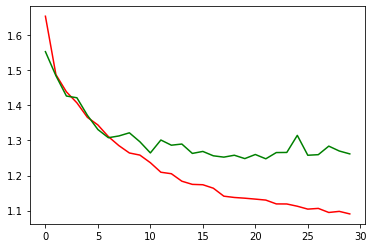

In [130]:
j = np.arange(30)
plt.plot(j, train_loss_list, 'r', j, val_loss_list, 'g')

In [131]:
def _get_accuracy(dataloader, Net):
    total = 0
    correct = 0
    Net.eval()
    for i, (images, labels) in enumerate(dataloader):
        images = Variable(images).float()
        labels = Variable(labels).float()

        outputs = Net(images)
    
        _, label_ind = torch.max(labels, 1)
        _, pred_ind = torch.max(outputs, 1)
        
        # converting to numpy arrays
        label_ind = label_ind.data.numpy()
        pred_ind = pred_ind.data.numpy()
        
        # get difference
        diff_ind = label_ind - pred_ind
        # correctly classified will be 1 and will get added
        # incorrectly classified will be 0
        correct += np.count_nonzero(diff_ind == 0)
        total += len(diff_ind)

    accuracy = correct / total
    # print(len(diff_ind))
    return accuracy

Net = Net.cpu().eval()
# _get_accuracy(trainloader)

In [132]:
print(_get_accuracy(trainloader, Net) * 100, '/', _get_accuracy(valloader, Net) * 100, '/', _get_accuracy(testloader, Net) * 100)

58.81849315068494 / 47.91666666666667 / 48.61111111111111


In [133]:
testing_Net = ConvNet()
testing_Net.load_state_dict(torch.load('1conv_softmax.pt'))
testing_Net.eval()
print(_get_accuracy(trainloader, testing_Net) * 100, '/', _get_accuracy(valloader, testing_Net) * 100, '/', _get_accuracy(testloader, testing_Net) * 100)

56.59246575342466 / 53.47222222222222 / 52.77777777777778


Even using running standard deviation of raw data doesn't help reduce overfitting significantly. So, next we try using running RMS of raw data.

### PyTorch implementation of `running_rms`

In [112]:
def running_rms(signal, window_size = 10):
    ''' Returns running rms of 3D signal (batch_size, length, channels)
    Note : torch.norm just gives vector 2-norm, so we need to divide it by
    sqrt(window_size) to make it the RMS value
    '''
    mean = torch.zeros_like(signal)
    n = np.sqrt(window_size)
    div = torch.tensor(np.array([n, n, n])).float()
    if torch.cuda.is_available() : 
        div = div.cuda()
    
    for i in range(signal.shape[0]) :
        for j in range(signal.shape[1] - window_size) : 
            mean[i][j] = signal[i][j : j + window_size].norm(dim = 0) / div
            
    for i in range(signal.shape[0]) :
        for j in range(signal.shape[1] - window_size, signal.shape[1]) :
            mean[i][j] = signal[i][j]
            
    return mean

### Shows working of `running_rms`

In [115]:
signal, label = next(iter(trainloader))
if torch.cuda.is_available() :
    signal = signal.cuda().float()
rms = running_rms(signal, window_size = 10)
print(rms.shape)
sig_ = signal[0].transpose(0, 1).cpu()
mean_ = rms[0].transpose(0, 1).cpu()
t = range(50)
plt.plot(t, sig_[1].data.numpy(), 'r', t, mean_[1].data.numpy(), 'b')

RuntimeError: expected backend CPU and dtype Double but got backend CPU and dtype Float

### Training network using `running_rms` processed data

In [117]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # defining layers
        self.conv1 = nn.Conv1d(3, 5, 3)
        self.conv2 = nn.Conv1d(5, 5, 3)
        self.fc1 = nn.Linear(46 * 5, 5)
#         self.mp = nn.MaxPool1d(2, 2)
#         self.dropout = nn.Dropout(p = 0.5)
#         self.bn1 = nn.BatchNorm1d(num_features = 5)
#         self.bn2 = nn.BatchNorm1d(num_features = 5)
#         self.bnfc = nn.BatchNorm1d(num_features = 5)
        
        nn.init.xavier_uniform_(self.conv1.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.conv2.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc1.weight, gain = nn.init.calculate_gain('sigmoid'))
        
    def forward(self, signal):
        signal_ = running_rms(signal, window_size = 10)
        signal_ = signal_.view(-1, 3, 50)
        out = F.relu(self.conv1(signal_))
        out = F.relu(self.conv2(out))
        out = out.view(-1, 46 * 5)
        out = F.log_softmax(self.fc1(out), dim = 1)
        return out

Net = ConvNet()
if torch.cuda.is_available():
    print('Model on GPU')
    Net = Net.cuda()

In [118]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net.parameters(), lr = 1e-3)

In [119]:
num_epochs = 30
total_step = len(trainset) // (train_batch_size * 150)
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, (images, labels) in enumerate(trainloader) :
        if torch.cuda.is_available():
            images = Variable(images).cuda().float()
            labels = Variable(labels).cuda()
        else : 
            images = Variable(images).float()
            labels = Variable(labels)
        
        _, target = torch.max(labels, 1)

        y_pred = Net(images)
        
        loss = criterion(y_pred, target)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 20 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    Net.eval()
    val = []
    with torch.no_grad() :
        for i, (images, labels) in enumerate(valloader) :
            if torch.cuda.is_available():
                images = Variable(images).cuda().float()
                labels = Variable(labels).cuda()
            else : 
                images = Variable(images).float()
                labels = Variable(labels)
                
            _, target = torch.max(labels, 1)

            # Forward pass
            outputs = Net(images)
            loss = criterion(outputs, target)
            val.append(loss)

    val_loss = (sum(val) / len(val)).item()
    val_loss_list.append(val_loss)
    print('epoch : ', epoch, ' / ', num_epochs, ' | TL : ', train_loss, ' | VL : ', val_loss)
    
    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(Net.state_dict(), '1conv_softmax.pt')

epoch =  0  step =  0  of total steps  24  loss =  1.8811068534851074
epoch =  0  step =  20  of total steps  24  loss =  1.3653590679168701
epoch =  0  step =  40  of total steps  24  loss =  1.2853695154190063
epoch =  0  step =  60  of total steps  24  loss =  1.291702389717102
epoch :  0  /  30  | TL :  1.3621268599000695  | VL :  1.3164602518081665
saving model
epoch =  1  step =  0  of total steps  24  loss =  1.2448471784591675
epoch =  1  step =  20  of total steps  24  loss =  1.0377711057662964
epoch =  1  step =  40  of total steps  24  loss =  1.0086761713027954
epoch =  1  step =  60  of total steps  24  loss =  1.180564522743225
epoch :  1  /  30  | TL :  1.2508377130717447  | VL :  1.3296135663986206
epoch =  2  step =  0  of total steps  24  loss =  1.1189979314804077
epoch =  2  step =  20  of total steps  24  loss =  1.2224631309509277
epoch =  2  step =  40  of total steps  24  loss =  1.1607489585876465
epoch =  2  step =  60  of total steps  24  loss =  1.193839907

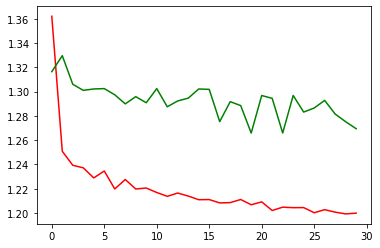

In [121]:
j = np.arange(30)
plt.plot(j, train_loss_list, 'r', j, val_loss_list, 'g')

In [124]:
def _get_accuracy(dataloader, Net):
    total = 0
    correct = 0
    Net.eval()
    for i, (images, labels) in enumerate(dataloader):
        images = Variable(images).float()
        labels = Variable(labels).float()
        
        if torch.cuda.is_available() : 
            images = images.cuda()
            labels = labels.cuda()

        outputs = Net(images)
    
        _, label_ind = torch.max(labels, 1)
        _, pred_ind = torch.max(outputs, 1)
        
        # converting to numpy arrays
        label_ind = label_ind.data.cpu().numpy()
        pred_ind = pred_ind.data.cpu().numpy()
        
        # get difference
        diff_ind = label_ind - pred_ind
        # correctly classified will be 1 and will get added
        # incorrectly classified will be 0
        correct += np.count_nonzero(diff_ind == 0)
        total += len(diff_ind)

    accuracy = correct / total
    # print(len(diff_ind))
    return accuracy

Net = Net.eval()

print(_get_accuracy(trainloader, Net) * 100, '/', _get_accuracy(valloader, Net) * 100, '/', _get_accuracy(testloader, Net) * 100)

testing_Net = ConvNet()
testing_Net.load_state_dict(torch.load('1conv_softmax.pt'))
testing_Net.eval()
print(_get_accuracy(trainloader, testing_Net) * 100, '/', _get_accuracy(valloader, testing_Net) * 100, '/', _get_accuracy(testloader, testing_Net) * 100)

50.171232876712324 / 44.44444444444444 / 45.13888888888889
48.88698630136986 / 45.13888888888889 / 43.75
